In [11]:
# all libraries required for the entire EDA

from requests import get
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Samuel Norman "Sam" Seaborn is a fictional character portrayed by Rob Lowe on the television serial drama The West Wing. Hence: sns
from seaborn_qqplot import pplot
import pandas as pd

import datetime as dt
from scipy import stats
from sklearn import linear_model 
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN

%matplotlib inline
sns.set(color_codes=True)

In [12]:
df_raw= pd.read_csv('df4.csv',sep=',',skipinitialspace=True)
df_raw = df_raw.drop('Unnamed: 0', axis=1)

In [13]:
df_raw.head()

,genetic,length,mass,exercise,smoking,alcohol,lifespan,sugar,BMI
0,73.9,185.0,99.7,0.9,0.0,2.4,73.1,6.9,29.1
1,86.0,172.0,105.4,1.8,8.1,0.4,85.0,4.2,35.6
2,83.3,176.0,111.4,1.1,0.8,4.6,81.6,7.5,36.0
3,82.8,164.0,111.4,4.7,11.8,1.0,81.0,2.9,41.4
4,78.7,178.0,71.6,1.5,8.3,4.9,75.0,5.5,22.6


In [14]:
temp = df_raw

train, test = train_test_split(temp, test_size=0.2, random_state=42)


X = train[['genetic', 'length', 'mass', 'exercise', 'smoking', 'alcohol', 'sugar','BMI']]
y = train.lifespan
regr = linear_model.LinearRegression()
regr.fit(X, y) 
score = regr.score(test[['genetic', 'length', 'mass', 'exercise', 'smoking', 'alcohol', 'sugar','BMI']],test.lifespan)
print(f'coefficient of determination(R\N{SUPERSCRIPT TWO}):', score)
a1=score

coefficient of determination(R²): 0.9735737147751526


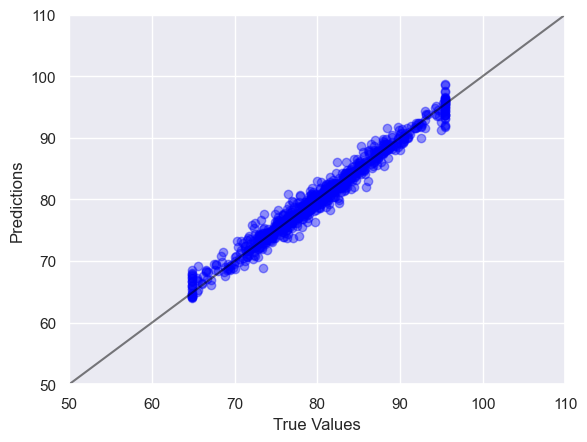

In [15]:
########################################
### PLOT TRUE VALUES vs PREDICTIONS ####
########################################

X_test = test[['genetic', 'length', 'mass', 'exercise', 'smoking', 'alcohol', 'sugar','BMI']]
y_test = test[['lifespan']]

p_test = regr.predict(X_test)

plt.scatter(y_test,p_test,c='blue', alpha=0.4)
plt.xlabel('True Values')
plt.ylabel('Predictions')

# plot diagonal line for comparison (prediction is exact)
lims=[50,110]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims,lims,c='black',alpha=0.5)
plt.show()

In general the errors should be normally distributed because we are assuming the input we get is normally distributed

In [ ]:
type(p_test)

In [16]:
########################################
### PLOT THE DISTRIBUTION OF ERRORS ####
########################################
error = p_test.flatten() - y_test.values
type(error)

numpy.ndarray

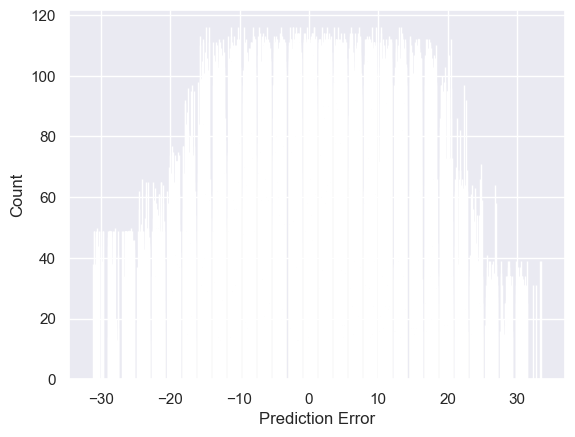

In [17]:
plt.hist(error,bins=30)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.show()

Looks normally distributed, lets check with a q-q plot (quantile-quantile plot)
> pip install statsmodels

In [ ]:
import statsmodels.api as sm

fig = sm.qqplot(error,line='45')
plt.show()

<img src='qq_interpretation.webp'>

Too peaked in the middle (also calle fat tailed, having both lef t and right skewedness)
> meaning that compared to the normal distribution there is more data located at the extremes of the distribution and less data in the center of the distribution. <br>
source: https://seankross.com/2016/02/29/A-Q-Q-Plot-Dissection-Kit.html

And perform the Shapiro-Wilk test to determine if the sample values came from a normal distribution

In [ ]:
from scipy.stats import shapiro
shapiro(error)

with p > 0.05 we can conlude the data comes from a normal distributed population

Lets check also with the normal test in scipy:
> The D’Agostino’s K^2 test calculates summary statistics from the data, namely kurtosis and skewness, to determine if the data distribution departs from the normal distribution, named for Ralph D’Agostino.

In [ ]:
from scipy.stats import normaltest
stat, p_val = normaltest(error)

# Set up a helper function for checking p-values against an alpha level, and printing result
def check_p_val(p_val, alpha):

    if p_val < alpha:
        print('With both values <0.05 evidence to reject the null hypothesis.')
    else:
        print('We do not have evidence to reject the null hypothesis.')

# Check the p-value of the normaltest
print('\nNormaltest p-value is: {:1.2e} \n'.format(p_val))

# With alpha value of 0.05, how should we proceed
check_p_val(p_val, alpha=0.05)

Seems conflicting results for the normality of the error, shapiro says yes, d'agostino says no

Normal distribution is one of the pre-requisites, however from: https://iovs.arvojournals.org/article.aspx?articleid=2128171 <Br>
> First, we suggest there is a common misconception of the need to meet the “normality assumption” in linear regression techniques, and the validity of performing linear regression is compromised when this assumption is violated. Typically, the “normality assumption” often is checked from the histogram of the dependent variable. Statistically, however, it is more accurate to check that the errors of a linear regression model are distributed normally or the dependent variable has a conditional normal distribution (rather than if the dependent variable complies fully with a normal distribution) when evaluating whether the “normality assumption” is fulfilled for linear regression. <


Lets see which distribution it does fit:

https://blog.minitab.com/en/statistics-in-the-field/a-field-guide-to-statistical-distributions

>pip install fitter

>Now, without any knowledge about the distribution or its parameter, what is the distribution that fits the data best ? Scipy has 80 distributions and the Fitter class will scan all of them, call the fit function for you, ignoring those that fail or run forever and finally give you a summary of the best distributions in the sense of sum of the square errors. 

In [ ]:
from fitter import Fitter, get_common_distributions, get_distributions

In [ ]:
get_distributions()

In [ ]:
f = Fitter(error, distributions=['norm','uniform','t','pearson3','loguniform', 'lognorm','chi2', 'f'])
f.fit()
# may take some time since by default, all distributions are tried
# but you call manually provide a smaller set of distributions
f.summary()

Lowest sumsquare error points towards a t-distribution, so we have to reject the usage of linear regression since its t-distributed ❌